In [73]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [191]:
import akantu as aka
import numpy as np
import matplotlib.pyplot as plt

from contact_mechanics_internodes import ContactMechanicsInternodes
from helper import plot_mesh

In [209]:
mesh_file = 'mesh/contact2d_circle.msh'
material_file = 'material/material.dat'
spatial_dimension = 2
aka.parseInput(material_file)

mesh = aka.Mesh(spatial_dimension)
mesh.read(mesh_file)

model = aka.SolidMechanicsModel(mesh)
model.initFull(_analysis_method=aka._implicit_dynamic)

model.applyBC(aka.FixedValue(0., aka._x), 'primary_fixed')
model.applyBC(aka.FixedValue(0., aka._y), 'primary_fixed')
model.applyBC(aka.FixedValue(0., aka._x), 'secondary_fixed')
model.applyBC(aka.FixedValue(-0.2, aka._y), 'secondary_fixed')

# Get positions of all nodes, surface connectivity and candidate nodes
positions = mesh.getNodes()
surface_connectivity = mesh.getConnectivity(aka._segment_2)
nodes_candidate_primary = mesh.getElementGroup('primary_candidates').getNodeGroup().getNodes().ravel()
nodes_candidate_secondary = mesh.getElementGroup('secondary_candidates').getNodeGroup().getNodes().ravel()

# Set initial conditions
internodes_model = ContactMechanicsInternodes(spatial_dimension, model, positions, surface_connectivity, nodes_candidate_primary, nodes_candidate_secondary)

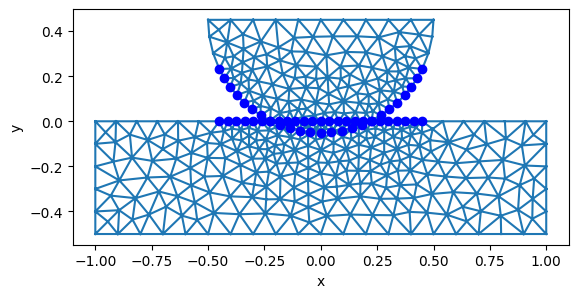

----> Starting iteration 1 <----
[40 60]
[]
Interpenetrating nodes:  []
Nodes in tension:  [ 3  4  8  9 39 61 77 78 79 80 96 97 98 99]


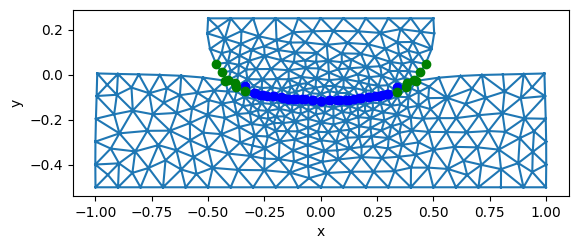

----> Starting iteration 2 <----
[40 60]
[]
Interpenetrating nodes:  []
Nodes in tension:  []


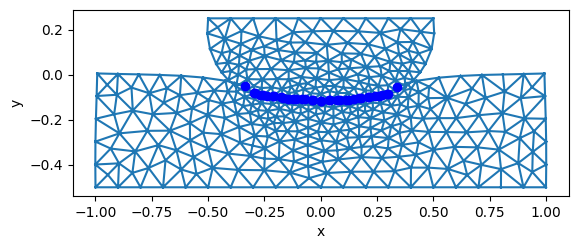

----> Starting iteration 3 <----
[40 60]
[]
Interpenetrating nodes:  []
Nodes in tension:  []


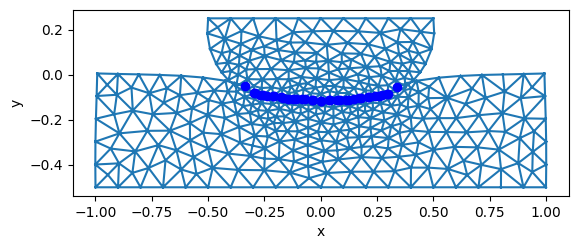

----> Starting iteration 4 <----
[40 60]
[]
Interpenetrating nodes:  []
Nodes in tension:  []


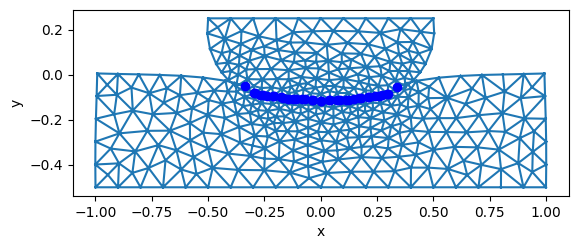

----> Starting iteration 5 <----
[40 60]
[]
Interpenetrating nodes:  []
Nodes in tension:  []


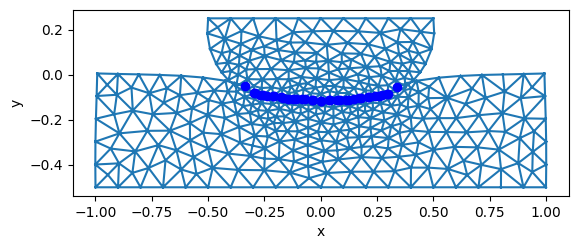

----> Starting iteration 6 <----
[40 60]
[]
Interpenetrating nodes:  []
Nodes in tension:  []


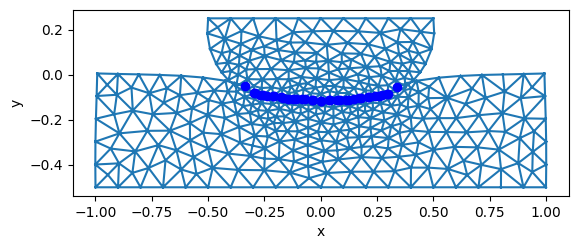

----> Starting iteration 7 <----
[40 60]
[]
Interpenetrating nodes:  []
Nodes in tension:  []


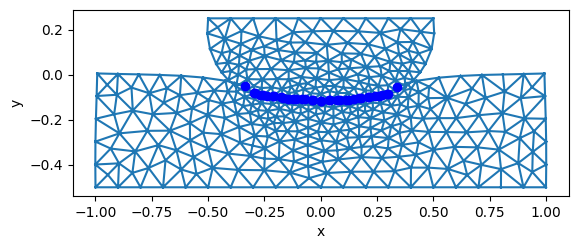

----> Starting iteration 8 <----
[40 60]
[]
Interpenetrating nodes:  []
Nodes in tension:  []


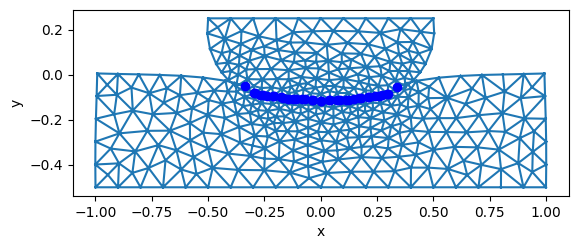

----> Starting iteration 9 <----
[40 60]
[]
Interpenetrating nodes:  []
Nodes in tension:  []


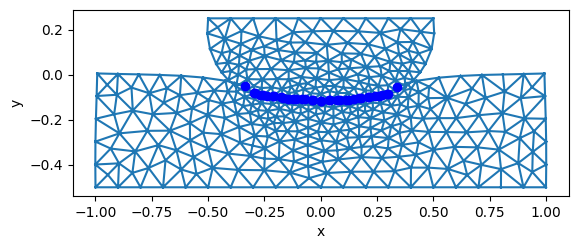

----> Starting iteration 10 <----
[40 60]
[]
Interpenetrating nodes:  []
Nodes in tension:  []


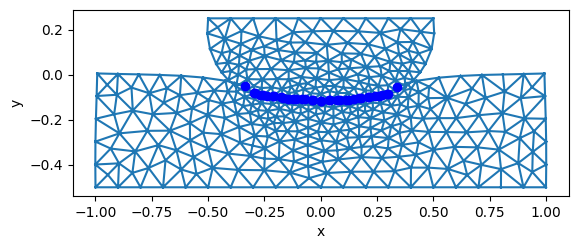

In [210]:
# Plot initial configuration
nodes_interface = np.union1d(internodes_model.nodes_interface_primary, internodes_model.nodes_interface_secondary)
plot_mesh(internodes_model.nodal_positions, mesh.getConnectivity(aka._triangle_3), nodes_interface)

max_iter = 10
for i in range(max_iter):
    print("----> Starting iteration", i+1, "<----")

    nodes_interface_primary_old = internodes_model.nodes_interface_primary
    nodes_interface_secondary_old = internodes_model.nodes_interface_secondary

    # Find the interface nodes
    internodes_model.find_interface_nodes()

    # Assemble model
    internodes_model.assemble_full_model()

    # Solve model
    displacements, lambdas = internodes_model.solve_direct()

    # Update the interface nodes and check if it converged
    converged = internodes_model.update_interface(displacements, lambdas)

    nodes_interface = np.union1d(internodes_model.nodes_interface_primary, internodes_model.nodes_interface_secondary)
    nodes_interpenetrating = np.union1d(
        np.setdiff1d(internodes_model.nodes_interface_primary, nodes_interface_primary_old),
        np.setdiff1d(internodes_model.nodes_interface_secondary, nodes_interface_secondary_old))
    nodes_tension = np.union1d(
        np.setdiff1d(nodes_interface_primary_old, internodes_model.nodes_interface_primary),
        np.setdiff1d(nodes_interface_secondary_old, internodes_model.nodes_interface_secondary))
    print("Interpenetrating nodes: ", nodes_interpenetrating)
    print("Nodes in tension: ", nodes_tension)

    # Plot the obtained solution
    positions_new = internodes_model.nodal_positions + displacements
    plot_mesh(positions_new, mesh.getConnectivity(aka._triangle_3), nodes_interface, nodes_interpenetrating, nodes_tension)

    if converged:
        print('\nsuccessfully converged in', i+1, 'iterations')
        break

In [203]:
compute_normals(positions_new, internodes_model.nodes_candidate_secondary, internodes_model.connectivity_candidate_secondary, internodes_model.dim)

array([[-0.85163125, -0.5241414 ],
       [ 0.73975811, -0.6728729 ],
       [-0.76994722, -0.63810758],
       [-0.51650308, -0.85628533],
       [-0.32005584, -0.94739868],
       [-0.26767592, -0.963509  ],
       [-0.21355695, -0.97693062],
       [-0.13110476, -0.99136852],
       [-0.02032766, -0.99979337],
       [ 0.02646605, -0.99964971],
       [ 0.05491279, -0.99849115],
       [ 0.12726315, -0.99186899],
       [ 0.1318233 , -0.99127323],
       [ 0.32536006, -0.9455902 ],
       [ 0.64421597, -0.76484363]])

In [205]:
np.linalg.norm(normals, axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [204]:
normals = compute_normals(positions_new, internodes_model.nodes_candidate_primary, internodes_model.connectivity_candidate_primary, internodes_model.dim)

In [171]:
triangle_indices

array([[ 95, 121, 133],
       [  4,  52, 173],
       [ 50,  51, 116],
       ...,
       [  9, 210, 254],
       [ 87,  10, 210],
       [ 10,  88, 210]], dtype=uint32)

In [175]:
nodes_primary = mesh.getElementGroup("primary").getNodeGroup().getNodes().ravel()

In [178]:
np.sum(np.isin(triangle_indices, nodes_primary).any(axis=1))

180

In [127]:
np.arange(12).reshape(3, 4)

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

In [126]:
np.isin(np.arange(12).reshape(3, 4), [3, 5, 1, 2, 7]).any(axis=1)

array([ True,  True, False])

In [128]:
 np.zeros((4, 10))

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])